## Data Extraction - Image Scraping
This notebook receives a json file from our scraping; currently scraping ebay data with bright data IDE for SOLD items via a search, then we extract the product detail pages from this and rerun each pdp page to get item details.  Running scraping on SOLD items gives us much more accurate target than a listing price however is harder as ebay protects this data more from scraping so we must use a proxy.  This notebook does some initial EDA then crawls the url for each product image and downloads them to a local directory with use of a random residential proxy connection (so not all requests come from 1 IP that would get blacklisted by ebay).  Once the images are donloaded a new csv file is created with an index of successfully downloaded images to run in the next notebook "pricing-item-with-image-similarity.ipynb".  This is necessary as with the residential proxy some images time out due to slow connections so we have some images not downloaded (I need to update script to retry for failed items but have run out of time).  

The current notebook can be run to get your own images from your own scraping json file however for easier demonstration purposes we have supplied some images in the repository.

In [3]:
#import libraries (note to self: runs on same pytorch local env)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import our libraries for file download and saving:
import pprint
import requests
import os
import re
from datetime import datetime

In [4]:
df = pd.read_json('scraping/ebay_json-vinyl.json')

## Initial EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ebay_id               410 non-null    float64
 1   title                 410 non-null    object 
 2   price                 410 non-null    object 
 3   shipping_price        410 non-null    object 
 4   location              410 non-null    object 
 5   condition             408 non-null    object 
 6   artist                408 non-null    object 
 7   release_year          231 non-null    object 
 8   image_url             410 non-null    object 
 9   full_description_url  410 non-null    object 
 10  input                 418 non-null    object 
 11  sleeve_grading        285 non-null    object 
 12  record_grading        291 non-null    object 
 13  sold_date             168 non-null    object 
 14  error                 8 non-null      object 
dtypes: float64(1), object(1

In [6]:
df.head(5)

,ebay_id,title,price,shipping_price,location,condition,artist,release_year,image_url,full_description_url,input,sleeve_grading,record_grading,sold_date,error
0,4.049467e+11,Vtg Fleetwood Mac - Rumours Vinyl Record LP & ...,"{'value': 19.9, 'currency': 'USD', 'symbol': '$'}",US $4.87 Economy Shipping. See detailsfor ship...,"Located in: Henderson, North Carolina, United ...",Used: An item that has been used previously. S...,Fleetwood Mac,1977,https://i.ebayimg.com/images/g/8KoAAOSwEFpmLZ5...,https://vi.vipr.ebaydesc.com/itmdesc/404946678...,"{'keyword': 'Fleetwood Mac Rumors Vinyl', 'cou...",NaN,NaN,NaN,NaN
1,2.261252e+11,Fleetwood Mac - Rumours - 1977 - Warner Bros B...,"{'value': 13.5, 'currency': 'USD', 'symbol': '$'}",US $4.85 Economy Shipping. See detailsfor ship...,"Located in: Keyport, New Jersey, United States",Used: An item that has been used previously. S...,"Fleetwood Mac, Lindsey Buckingham, Stevie Nicks",1977,https://i.ebayimg.com/images/g/u0cAAOSwGdJmM89...,https://vi.vipr.ebaydesc.com/itmdesc/226125201...,"{'keyword': 'Fleetwood Mac Rumors Vinyl', 'cou...",Good Plus (G+),Very Good Plus (VG+),NaN,NaN
2,3.951387e+11,Barry White Vinyl Record Lot - Can't Get Enoug...,"{'value': 49.99, 'currency': 'USD', 'symbol': ...",Free Economy Shipping. See detailsfor shipping...,"Located in: Merrimack, New Hampshire, United S...",UsedAn item that has been used previously. See...,"BEATLES, Barry White",NaN,https://i.ebayimg.com/images/g/rVIAAOSwE1NlptS...,https://vi.vipr.ebaydesc.com/itmdesc/395138741...,"{'keyword': 'Beatles Abbey Road Vinyl', 'count...",NaN,NaN,NaN,NaN
3,1.667386e+11,FLEETWOOD MAC - Rumours - Vinyl L.P Warner Bro...,"{'value': 16, 'currency': 'USD', 'symbol': '$'}",US $5.50 Economy Shipping. See detailsfor ship...,"Located in: Saint Louis, Missouri, United States",Used: An item that has been used previously. S...,Fleetwood Mac,1977,https://i.ebayimg.com/images/g/zK0AAOSwEFpmJj0...,https://vi.vipr.ebaydesc.com/itmdesc/166738567...,"{'keyword': 'Fleetwood Mac Rumors Vinyl', 'cou...",Very Good (VG),Good Plus (G+),"May 06, 2024 16:11:12 PDT",NaN
4,2.047300e+11,CREAM ERIC CLAPTON LP VINYL LOT ORIGINAL LAYLA...,"{'value': 41, 'currency': 'USD', 'symbol': '$'}",US $5.61 Economy Shipping. See detailsfor ship...,"Located in: Patchogue, New York, United States",Used: An item that has been used previously. S...,"Cream, Eric Clapton, Derek and the Dominos",NaN,https://i.ebayimg.com/images/g/KSYAAOSwmb1mEZZ...,https://vi.vipr.ebaydesc.com/itmdesc/204729988...,"{'keyword': 'Cream Disraeli Gears Vinyl', 'cou...",Very Good Plus (VG+),Excellent (EX),"Apr 11, 2024 17:02:23 PDT",NaN


In [7]:
# Count total NaN on each column in a DataFrame, we have a lot missing and can drop a few:
print(f" \nMissing or Null Value Count: \n\n{df.isna().sum()}\n\nPercent Missing: \n{df.isna().sum() * 100 / len(df)}\n")

 
Missing or Null Value Count: 

ebay_id                   8
title                     8
price                     8
shipping_price            8
location                  8
condition                10
artist                   10
release_year            187
image_url                 8
full_description_url      8
input                     0
sleeve_grading          133
record_grading          127
sold_date               250
error                   410
dtype: int64

Percent Missing: 
ebay_id                  1.913876
title                    1.913876
price                    1.913876
shipping_price           1.913876
location                 1.913876
condition                2.392344
artist                   2.392344
release_year            44.736842
image_url                1.913876
full_description_url     1.913876
input                    0.000000
sleeve_grading          31.818182
record_grading          30.382775
sold_date               59.808612
error                   98.086124
dtype

In [8]:
# Filter rows where the 'price' column does not contain dictionary values
#these should only be the error columns where the scraper did not retrive anything:
non_dict_rows = df[~df['price'].apply(lambda x: isinstance(x, dict))]
print('Rows with target not a dict:', non_dict_rows)

Rows with target not a dict:      ebay_id title price shipping_price location condition artist  \
410      NaN   NaN   NaN            NaN      NaN       NaN    NaN   
411      NaN   NaN   NaN            NaN      NaN       NaN    NaN   
412      NaN   NaN   NaN            NaN      NaN       NaN    NaN   
413      NaN   NaN   NaN            NaN      NaN       NaN    NaN   
414      NaN   NaN   NaN            NaN      NaN       NaN    NaN   
415      NaN   NaN   NaN            NaN      NaN       NaN    NaN   
416      NaN   NaN   NaN            NaN      NaN       NaN    NaN   
417      NaN   NaN   NaN            NaN      NaN       NaN    NaN   

    release_year image_url full_description_url  \
410          NaN       NaN                  NaN   
411          NaN       NaN                  NaN   
412          NaN       NaN                  NaN   
413          NaN       NaN                  NaN   
414          NaN       NaN                  NaN   
415          NaN       NaN                 

In [9]:
# Drop the rows where the 'price' column does not contain dictionary values
df = df[df['price'].apply(lambda x: isinstance(x, dict))]

In [10]:
#split price data into further columns sold and currency 
df['sold'] = df['price'].apply(lambda x: x['value'])
df['sold_currency'] = df['price'].apply(lambda x: x['currency'])

In [11]:
#shipping is a little more complex as it is mixed data
def extract_decimal_number(cell_value):
    decimal_pattern = r'\d+\.\d+'
    match = re.search(decimal_pattern, str(cell_value))
    if match:
        return float(match.group())
    else:
        return None

df['shipping_cost'] = df['shipping_price'].apply(extract_decimal_number)

In [71]:
# change the sold date column from a string to a date
#TO DO: change date to UTC?
#df['sold_date'] = pd.to_datetime(df['sold_date'], format='%b %d, %Y %H:%M:%S %Z')

In [12]:
#drop some other columns that don't serve a purpose/duplicated data
#let's drop columns missing more than say 30% of data as we can't impute them properly, id is also not needed:
df = df.drop(['price', 'shipping_price', 'full_description_url', 'input', 'error', 'sold_currency'], axis = 1)
df.head(1)

,ebay_id,title,location,condition,artist,release_year,image_url,sleeve_grading,record_grading,sold_date,sold,shipping_cost
0,4.049467e+11,Vtg Fleetwood Mac - Rumours Vinyl Record LP & ...,"Located in: Henderson, North Carolina, United ...",Used: An item that has been used previously. S...,Fleetwood Mac,1977,https://i.ebayimg.com/images/g/8KoAAOSwEFpmLZ5...,NaN,NaN,NaN,19.9,4.87


/Users/stephenthorpe/anaconda3/envs/pytorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 1.0, 'Distribution of Sold Price')]

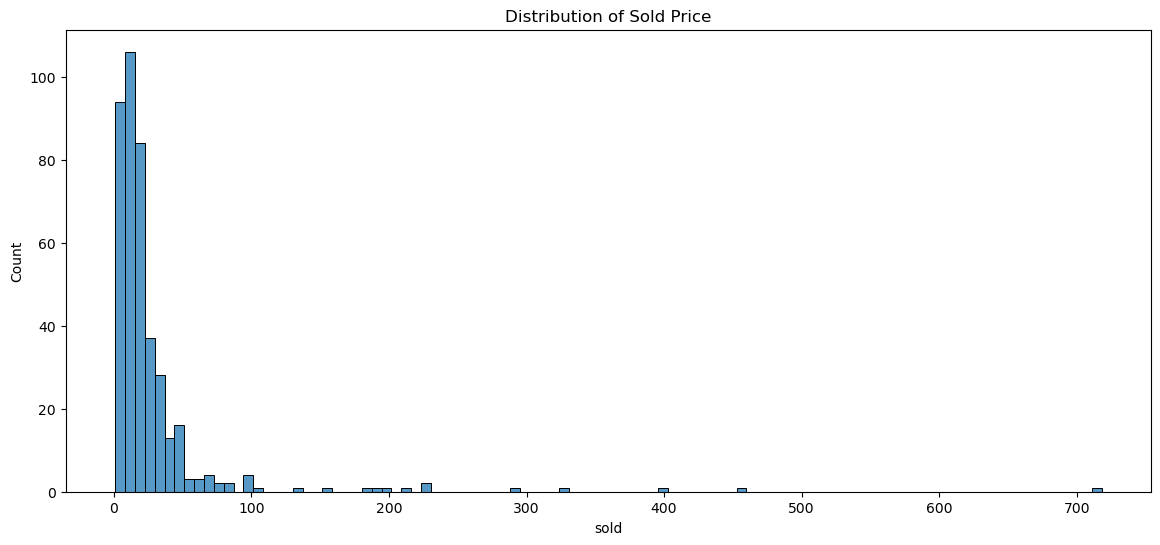

In [13]:
#let's look at the distribution of our target data price:
x_data =df['sold']
fig, ax = plt.subplots (figsize=(14, 6))
sns.histplot(x_data, bins=100).set(title='Distribution of Sold Price')

In [14]:
df['sold'].mean()

28.49846341463415

In [15]:
df['sold'].sum()

11684.37

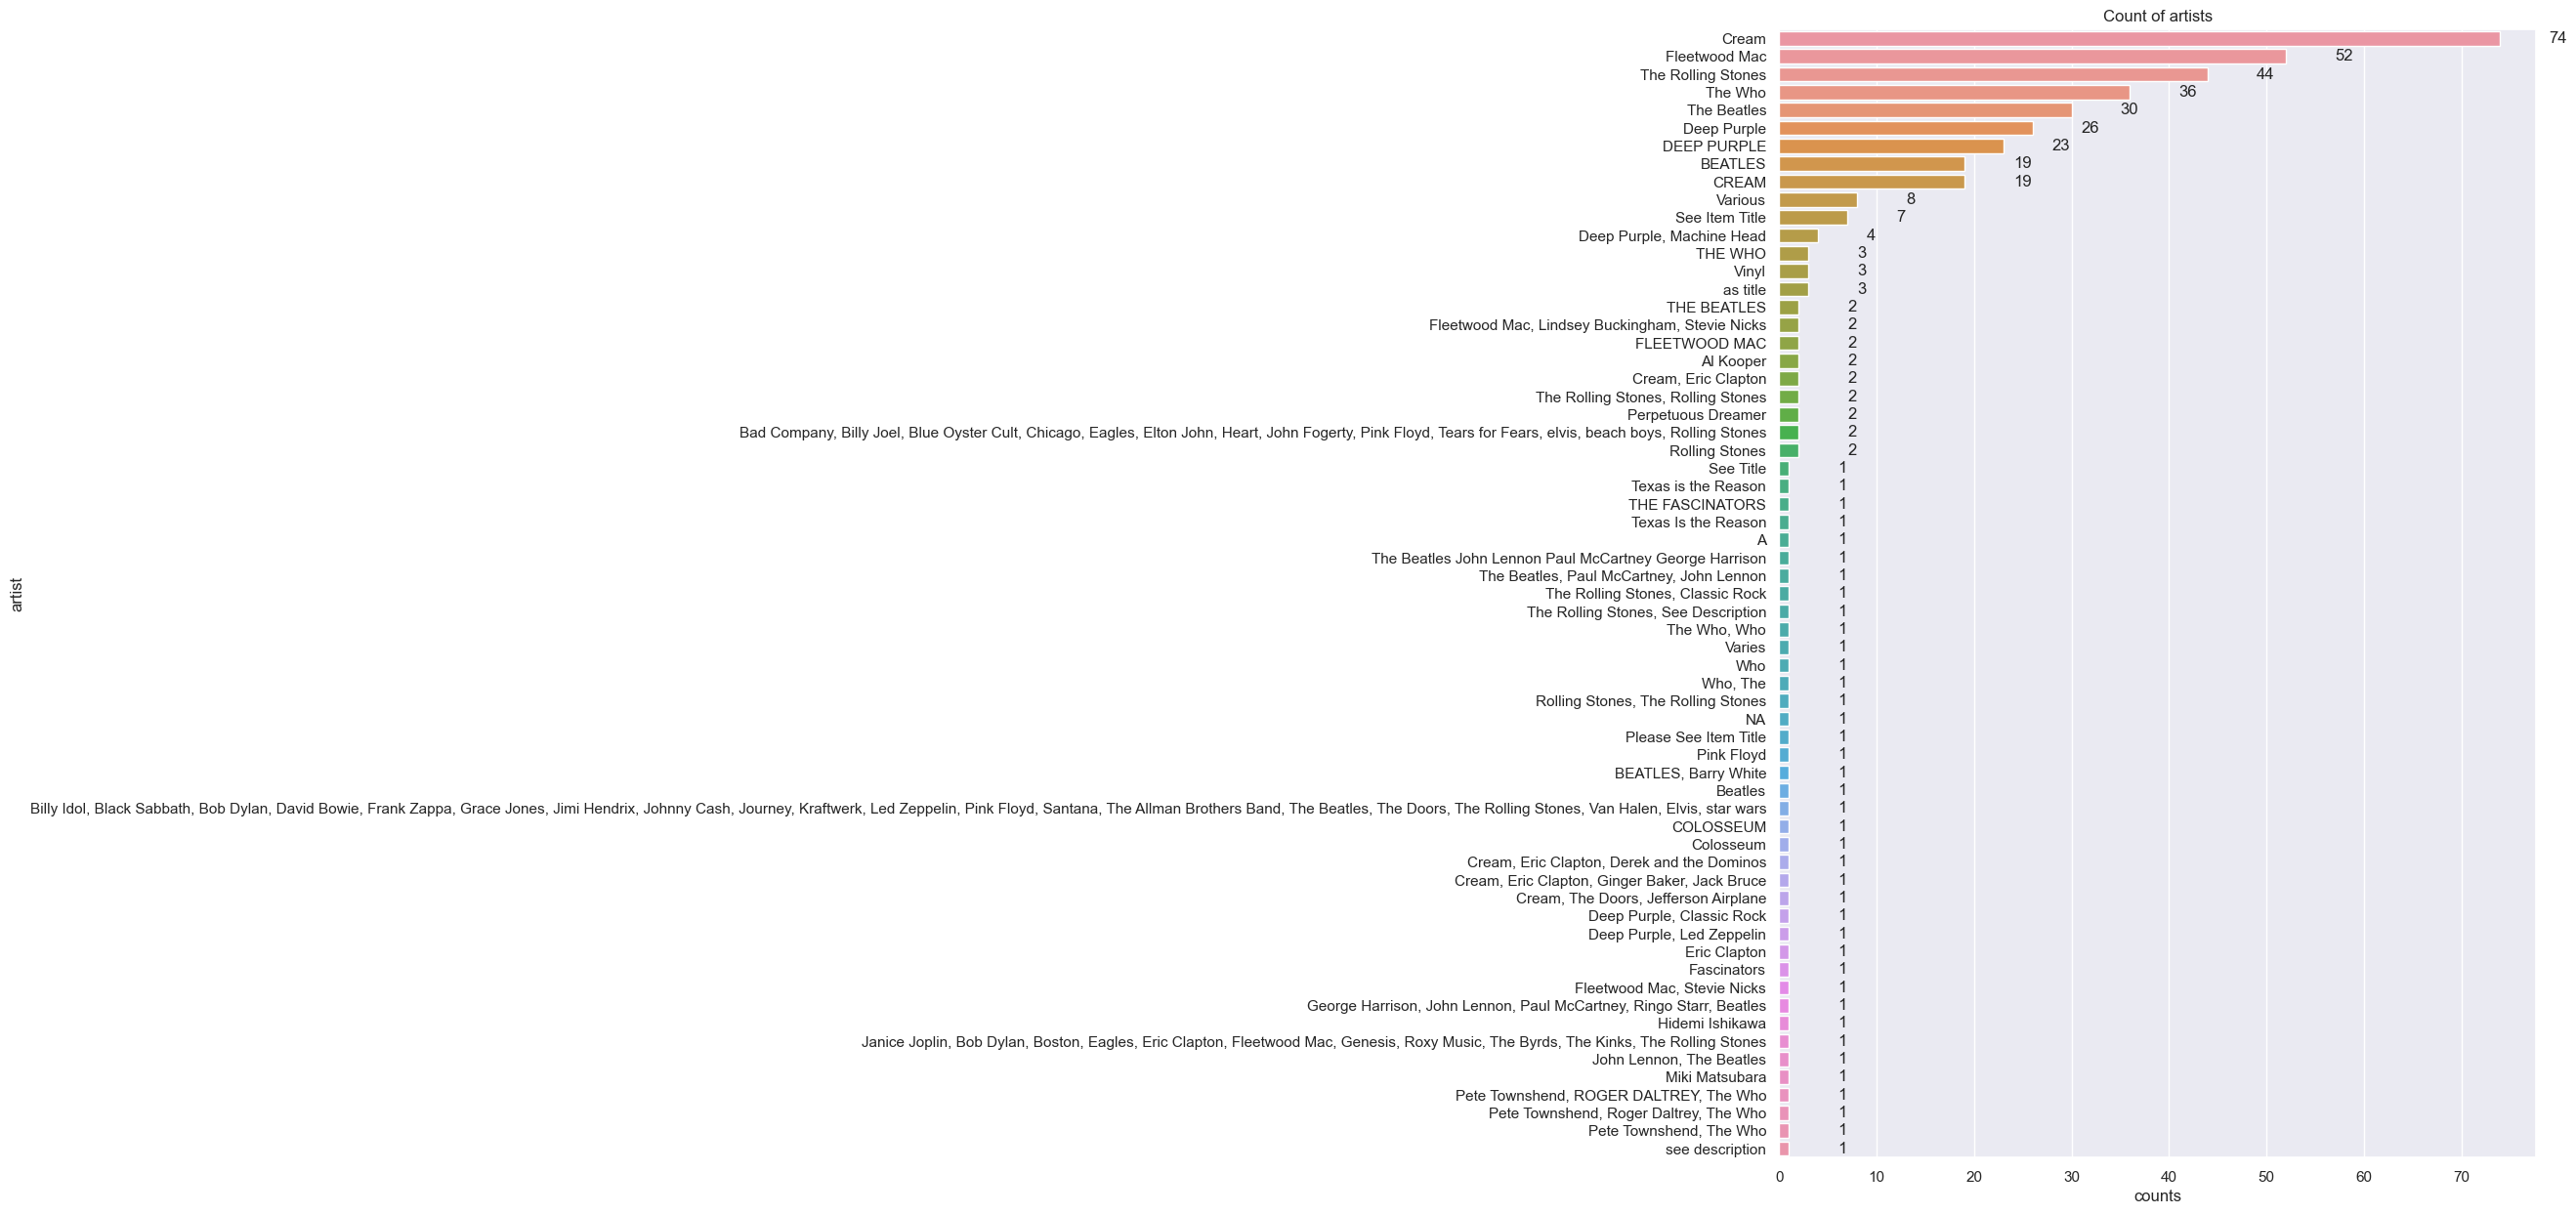

In [98]:
#let's investigate the counts per artist, we should take into account some pdp's are 'groups' of multiple 
#items, let's hope our image similarity helps filter these out
sns.set(rc={"figure.figsize":(10,15)})
ax = sns.barplot(data=df.groupby(by='artist').size().reset_index(name="counts").sort_values('counts', ascending=False), 
              y='artist', x='counts')
ax.set(title="Count of artists") # title barplot

# label each bar in barplot
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+5, # x-coordinate position of data label, padded 5 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = "{:.0f}".format(width), # data label, formatted to ignore decimals
    va = "center") # sets vertical alignment (va) to center

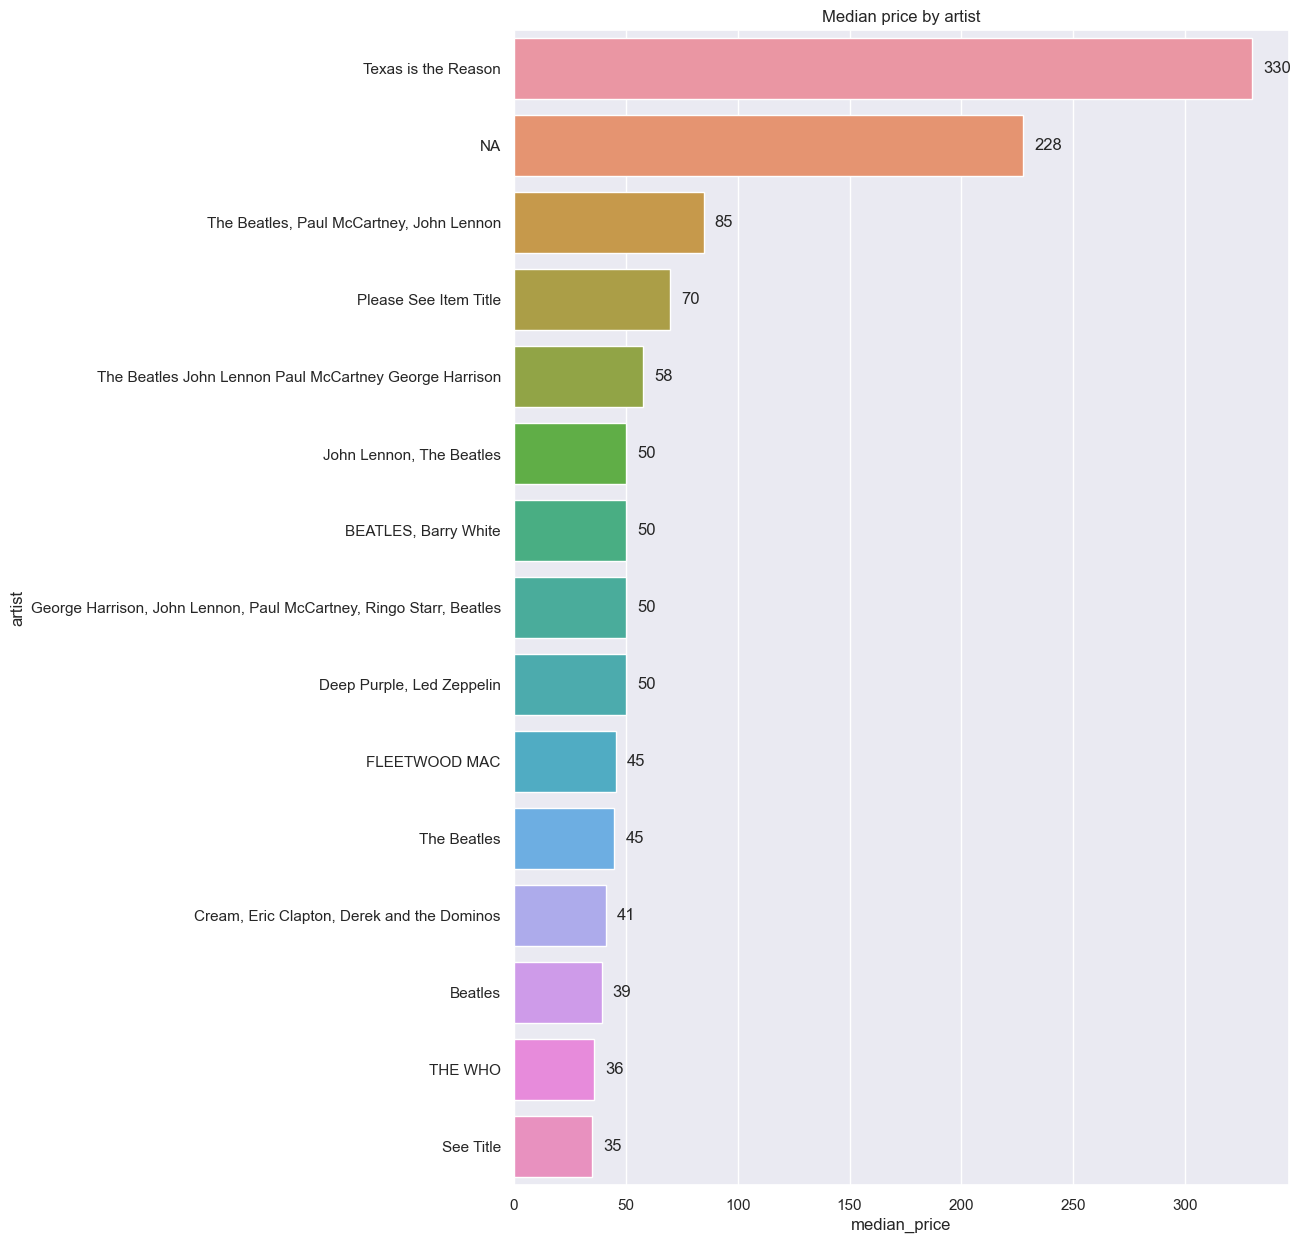

In [100]:
sns.set(rc={"figure.figsize":(10,15)})
ax = sns.barplot(data=df.groupby(by='artist')['sold'].median().reset_index(name="median_price").sort_values('median_price', ascending=False).head(15), 
              y='artist', x='median_price')
ax.set(title="Median price by artist") # title barplot

# label each bar in barplot
for p in ax.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    # adding text to each bar
    ax.text(x = width+5, # x-coordinate position of data label, padded 5 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = "{:.0f}".format(width), # data label, formatted to ignore decimals
    va = "center") # sets vertical alignment (va) to center

In [51]:
#utility to help debug issues for our certs and file paths as ssl cert required for residential brightdata proxy
# NOTE: python does NOT use certificates from system/keychain but uses certifi path
# so usefull to lookup path to use for requests.get - verify if ssl missing 
import os
import ssl 
import certifi
cwd = os.getcwd()
print(cwd)
print(ssl.get_default_verify_paths().openssl_cafile)
print(certifi.where())
file_path = '/Users/stephenthorpe/Desktop/data-science/vision-similarity/scraping/images'
if os.path.exists(file_path):
    with open(file_path, 'r') as file:
        # Read and process the file
        content = file.read()
else:
    print(f"Error: File not found at {file_path}")

/Users/stephenthorpe/Desktop/data-science/vision-similarity


In [16]:
#select some image urls from our dataframe
image_urls = np.array(df.loc[:,'image_url'])
print('Images in dataframe to be downloaded:', len(image_urls))
#image_urls

Images in dataframe to be downloaded: 410


In [17]:
#setup variables for proxy connection to bright data so scraping images is not blocked on ebay
# see for guide: https://brightdata.zendesk.com/hc/en-us/articles/13719730577937-API#heading-1
host = 'brd.superproxy.io'
port = 22225

username = 'brd-customer-hl_715fcd36'
#zone = '-zone-residential_proxy1'
zone = '-zone-datacenter_proxy1'
#password = 'hh7fehbqtgxn' 
password = '4tr5ony6grxk'
#country = '-country-us' #set proxy location to US

proxy_url = f'http://{username}{zone}:{password}@{host}:{port}'

proxies = {
    'http': proxy_url,
    'https': proxy_url
}
#connect to check our proxy ip and location 
url = "http://lumtest.com/myip.json"
response = requests.get(url, proxies=proxies)
print(f"\nConnected to download images using the following Proxy: ")
pprint.pprint(response.json())

# Set the directory where we want to save the image
save_directory = '/Users/stephenthorpe/Desktop/data-science/vision-similarity/scraping/files'

# Download and save each image
#put thios into 'get' request for residential proxy: verify='/Users/stephenthorpe/anaconda3/envs/pytorch/ssl/certs/ca.crt'
image_files = [] 
for image_url in image_urls:
    image_name = image_url.split('/')[-2] + '_' + image_url.split('/')[-1]
    path = os.path.join(save_directory, image_name)
    response = requests.get(image_url, proxies=proxies)
    if response.status_code == 200:
        with open(path, 'wb') as file:
            file.write(response.content)
            image_file = [image_url, image_name]
            image_files.append(image_file)
    elif response.status_code == 502:
        response = requests.get(image_url, proxies=proxies)
        if response.status_code == 200:
            with open(path, 'wb') as file:
                file.write(response.content)
                image_file = [image_url, image_name]
                image_files.append(image_file)
    else: print('response error code:',response.status_code,'for', image_url)
print('successfully saved the following images:', len(image_files))


Connected to download images using the following Proxy: 
{'asn': {'asnum': 203020, 'org_name': 'HostRoyale Technologies Pvt Ltd'},
 'country': 'US',
 'geo': {'city': 'New York',
         'latitude': 40.7123,
         'longitude': -74.0068,
         'lum_city': 'newyork',
         'lum_region': 'ny',
         'postal_code': '10004',
         'region': 'NY',
         'region_name': 'New York',
         'tz': 'America/New_York'},
 'ip': '168.151.139.14'}
successfully saved the following images: 410


In [18]:
# add saved image file names to dataframe for more convenient access
for image_url, image_name in image_files:
    df.loc[df['image_url'] == image_url, ['image_file']] = image_name   #lookup row based on url and add our new image_file name value 
df.head(10)

,ebay_id,title,location,condition,artist,release_year,image_url,sleeve_grading,record_grading,sold_date,sold,shipping_cost,image_file
0,4.049467e+11,Vtg Fleetwood Mac - Rumours Vinyl Record LP & ...,"Located in: Henderson, North Carolina, United ...",Used: An item that has been used previously. S...,Fleetwood Mac,1977,https://i.ebayimg.com/images/g/8KoAAOSwEFpmLZ5...,NaN,NaN,NaN,19.90,4.87,8KoAAOSwEFpmLZ53_s-l500.webp
1,2.261252e+11,Fleetwood Mac - Rumours - 1977 - Warner Bros B...,"Located in: Keyport, New Jersey, United States",Used: An item that has been used previously. S...,"Fleetwood Mac, Lindsey Buckingham, Stevie Nicks",1977,https://i.ebayimg.com/images/g/u0cAAOSwGdJmM89...,Good Plus (G+),Very Good Plus (VG+),NaN,13.50,4.85,u0cAAOSwGdJmM89m_s-l500.webp
2,3.951387e+11,Barry White Vinyl Record Lot - Can't Get Enoug...,"Located in: Merrimack, New Hampshire, United S...",UsedAn item that has been used previously. See...,"BEATLES, Barry White",NaN,https://i.ebayimg.com/images/g/rVIAAOSwE1NlptS...,NaN,NaN,NaN,49.99,NaN,rVIAAOSwE1NlptSv_s-l500.webp
3,1.667386e+11,FLEETWOOD MAC - Rumours - Vinyl L.P Warner Bro...,"Located in: Saint Louis, Missouri, United States",Used: An item that has been used previously. S...,Fleetwood Mac,1977,https://i.ebayimg.com/images/g/zK0AAOSwEFpmJj0...,Very Good (VG),Good Plus (G+),"May 06, 2024 16:11:12 PDT",16.00,5.50,zK0AAOSwEFpmJj0Q_s-l500.webp
4,2.047300e+11,CREAM ERIC CLAPTON LP VINYL LOT ORIGINAL LAYLA...,"Located in: Patchogue, New York, United States",Used: An item that has been used previously. S...,"Cream, Eric Clapton, Derek and the Dominos",NaN,https://i.ebayimg.com/images/g/KSYAAOSwmb1mEZZ...,Very Good Plus (VG+),Excellent (EX),"Apr 11, 2024 17:02:23 PDT",41.00,5.61,KSYAAOSwmb1mEZZh_s-l1600.webp
5,3.153330e+11,"Fleetwood Mac "" Rumors "" Vinyl 12"" LP 2009 Rei...","Located in: Birmingham, Alabama, United States",Used: An item that has been used previously. S...,Fleetwood Mac,2009,https://i.ebayimg.com/images/g/5ocAAOSwilxmMV~...,Very Good Plus (VG+),Very Good Plus (VG+),"May 07, 2024 20:02:01 PDT",29.00,4.13,5ocAAOSwilxmMV~O_s-l1600.webp
6,3.350396e+11,FLEETWOOD MAC - RUMOURS - WARNER BROS RECORDS LP,"Located in: Cleveland, Ohio, United States",UsedAn item that has been used previously. See...,Fleetwood Mac,NaN,https://i.ebayimg.com/images/g/czIAAOSwC2xlDQ1...,Very Good Plus (VG+),Excellent (EX),NaN,24.50,4.00,czIAAOSwC2xlDQ1-_s-l500.webp
7,3.152878e+11,cream disraeli gears vinyl lp ex condition 196...,"Located in: Colchester, United Kingdom",UsedAn item that has been used previously. See...,Cream,1967,https://i.ebayimg.com/images/g/xO0AAOSwQA9mGDC...,Excellent (EX),Excellent (EX),NaN,29.99,17.00,xO0AAOSwQA9mGDCo_s-l1600.webp
8,3.754181e+11,Fleetwood Mac – Rumours- 1977 Warner Bros. Rec...,"Located in: Luther, Oklahoma, United States",Used: An item that has been used previously. S...,Fleetwood Mac,1977,https://i.ebayimg.com/images/g/NQ4AAOSwWp5mO35...,Very Good Plus (VG+),Very Good (VG),NaN,21.00,4.13,NQ4AAOSwWp5mO35B_s-l500.webp
9,3.353722e+11,BEATLES ABBEY ROAD APPLE AP8815 JAPAN VINYL LP,"Located in: Shibuya, Tokyo, Japan",UsedAn item that has been used previously. See...,BEATLES,NaN,https://i.ebayimg.com/images/g/7XMAAOSwZRtmMMZ...,E-,E-,"May 08, 2024 18:06:08 PDT",7.50,18.00,7XMAAOSwZRtmMMZs_s-l1600.webp


In [19]:
#select rows that actually have files saved for them:
dff = df[df['image_file'].notnull()]

# Get the current date
current_date = datetime.now().strftime('%Y-%m-%d-')

# Specify the directory to save the file
save_dir = '/Users/stephenthorpe/Desktop/data-science/vision-similarity/scraping'

# Construct the filename
filename = f'EBAY_images_{current_date}.csv'
filepath = os.path.join(save_dir, filename)

#write our DF to a csv for convenience 
dff.to_csv(filepath, index=False)


In [ ]:
# TO DO!
#fix scraping 'sold_date' as we should have 100% of data on this
#extract country, city from location
#work out way of imputing release year
#work out way of extracting keywords like edition etc
#add pagination support to search results
#download full descriptions?
#add a counter to show percentage complete (len of array/ current item printed to screen)
#add value to SOLD_DATE for other albums


#find out what features have the largest impact on our selling price (also look at adding data like time to sale, offers etc)
#add more rows of data with pagination to get better price distribution
#compare images first to make sure not a t shirt or other product?

